<a href="https://colab.research.google.com/github/JZhouSaclay/DataChallenge/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch import nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fill_with_cyclic_mean(df, col):
    for index in df[df[col].isnull()].index:  # parcourir les données manquantes
        # obtenir les informations temporaires de la donnée manquante
        month = df.loc[index, 'Month']
        day = df.loc[index, 'Day']
        hour = df.loc[index, 'Hour']

        # trouver les valeurs de même instant des autres années
        similar_time_data = df[(df['Month'] == month) &
                               (df['Day'] == day) &
                               (df['Hour'] == hour) &
                               (~df[col].isnull())][col]

        # calculer une moyenne
        if not similar_time_data.empty:
            df.at[index, col] = similar_time_data.mean()

def dataProcessing(data_name):
    public_df = pd.read_csv(f'./{data_name}.csv')

    public_df['date'] = pd.to_datetime(public_df['date'], utc=True)
    public_df['date_utc'] = public_df['date'].dt.tz_convert('UTC')

    # les infos de temps basique
    public_df['Month'] = public_df['date_utc'].dt.month
    public_df['Year'] = public_df['date_utc'].dt.year
    public_df['Day'] = public_df['date_utc'].dt.day
    public_df['Hour'] = public_df['date_utc'].dt.hour
    public_df['Week'] = public_df['date'].dt.isocalendar().week
    public_df['Weekday'] = public_df['date_utc'].dt.weekday
    public_df['toy'] = public_df['date'].dt.dayofyear
    public_df['Minute'] = public_df['date_utc'].dt.minute
    public_df['Half_Hour'] = public_df['Hour'] * 2 + (public_df['Minute'] // 30)

    # les vacances et jours fériés
    fr_holidays = holidays.France()
    public_df['is_holiday'] = public_df['date_utc'].dt.date.apply(lambda x: x in fr_holidays)

    public_df['is_summer_vacation'] = public_df['date_utc'].apply(
        lambda x: (x.month == 8) or (x.month == 6 and x.day >= 10) or (x.month == 7)
    )
    public_df['vacances'] = public_df['date_utc'].apply(
        lambda x: (x.month == 8 and x.day >= 1 and x.day <= 15) or
                  (x.month == 12 and x.day >= 25) or
                  (x.month == 1 and x.day <= 2)
    )
    public_df['big_holiday'] = public_df['date_utc'].apply(
        lambda x: (x.month == 5 and x.day == 1) or
                  (x.month == 7 and x.day == 14) or
                  (x.month == 12 and x.day == 25) or
                  (x.month == 1 and x.day == 1)
    )

    # pandémie
    pandemic_periods = [
        ('2020-03-17', '2020-05-10'),
        ('2020-10-30', '2020-12-14'),
        ('2021-02-27', '2021-02-28'),
        ('2021-03-06', '2021-03-07'),
        ('2021-04-01', '2021-04-04')
    ]
    public_df['is_pandemic'] = False
    for start, end in pandemic_periods:
        public_df['is_pandemic'] |= public_df['date_utc'].between(start, end)

    public_df['Season'] = public_df['Month'].apply(
        lambda month: 0 if month in [3,4, 5] else
                      1 if month in [6, 7, 8,9] else
                      2 if month in [10, 11] else
                      3
    )

    # type de jours dans la semaine
    public_df['is_weekend'] = public_df['Weekday'].apply(lambda x: x in [5, 6])
    public_df['is_workday'] = public_df['Weekday'].apply(lambda x: x in [1, 2, 3])
    public_df['is_transday'] = public_df['Weekday'].apply(lambda x: x in [0, 4])
    public_df['is_vacation'] = public_df['Week'].apply(lambda x: x in range(30, 35))

    # sin/cos encoding de 48 dimensions
    time_variables = {
        'Half_Hour': 48,      #48 intervalles de demi-heure dans une journée
        'Weekday': 7,         # 7 j/semaine
        'Month': 12,
        'Season': 4,
        'toy': 365,
    }
    max_k = 48 # dim max

    # on utilise dict pour tout enregistrer, puis concaténer, pour éviter de trop modifier le dataframe
    fourier_features = {}

    for var, period in time_variables.items():
        for k in range(1, max_k + 1):
            fourier_features[f'sin_{var}_k{k}'] = np.sin(2 * np.pi * k * public_df[var] / period)
            fourier_features[f'cos_{var}_k{k}'] = np.cos(2 * np.pi * k * public_df[var] / period)

    public_df = pd.concat([public_df, pd.DataFrame(fourier_features)], axis=1)

    return public_df


def weatherProcessing(data_name):
    weather = pd.read_parquet(f'./{data_name}.parquet')
    weather['date'] = pd.to_datetime(weather['date'], utc=True)
    variables = ['t', 'u', 'td', 'ff', 'dd']

    # on supprime celui qui a trop de données manquantes, impossible de remplir
    weather_metropole = weather[weather['nom_epci'] != "Métropole Toulon-Provence-Méditerranée"]

    weather_avg_metropole = weather_metropole.groupby(['nom_epci', 'date'])[variables].mean().reset_index()
    weather_pivot_metropole = weather_avg_metropole.pivot_table(index='date', columns='nom_epci', values=variables)
    weather_pivot_metropole = weather_pivot_metropole.interpolate(method='linear', limit_direction='both')
    weather_pivot_metropole.index = pd.to_datetime(weather_pivot_metropole.index, utc=True)
    weather_resampled_metropole = weather_pivot_metropole.resample('30min').interpolate(method='linear')

    # niveau Région
    weather_avg = weather.groupby(['nom_reg', 'date'])[variables].mean().reset_index()
    weather_pivot = weather_avg.pivot_table(index='date', columns='nom_reg', values=variables)
    weather_pivot = weather_pivot.interpolate(method='linear', limit_direction='both')
    weather_pivot.index = pd.to_datetime(weather_pivot.index, utc=True)
    weather_resampled = weather_pivot.resample('30min').interpolate(method='linear')

    # ajout de nouvelles colonnes correspondantes à chaque variables de météo
    weather_resampled_metropole.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled_metropole.columns]
    weather_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled.columns]

    # reset index avec date
    if 'date' not in weather_resampled_metropole.columns:
        weather_resampled_metropole.reset_index(inplace=True)
    if 'date' not in weather_resampled.columns:
        weather_resampled.reset_index(inplace=True)

    # on fait d'abord pour ville, puis région, ensuite concat
    weather_df = pd.merge(weather_resampled_metropole, weather_resampled, on='date', how='outer')

    return weather_df

class MLPWithAttentionAll(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=25, num_layers=3, dropout_rate=0.2):
        super(MLPWithAttentionAll, self).__init__()

        self.layers = nn.ModuleList()
        self.batchnorms = nn.ModuleList()
        self.attentions = nn.ModuleList()

        # input
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.batchnorms.append(nn.BatchNorm1d(hidden_dim))
        self.attentions.append(nn.Linear(hidden_dim, 1))  # self.attention

        # hidden
        for _ in range(num_layers - 1):  # num_layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.batchnorms.append(nn.BatchNorm1d(hidden_dim))
            self.attentions.append(nn.Linear(hidden_dim, 1))

        # output
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        for i in range(len(self.layers)):
            x = F.relu(self.layers[i](x))
            x = self.batchnorms[i](x)  # batch normalisation
            attn_weights = torch.sigmoid(self.attentions[i](x))
            x = x * attn_weights
            x = self.dropout(x)

        x = self.output_layer(x)  # les 25 colonnes en une fois
        return x

def RMSE(y_pred, y_true):
    return torch.sqrt(((y_pred - y_true)**2).mean())



In [ ]:

conso_df = dataProcessing("train")
weather_data = weatherProcessing("meteo")

column_names = conso_df.columns.tolist()
date_utc_index = column_names.index('date_utc')
explanatory_vars = column_names[:date_utc_index]
for col in explanatory_vars:
    fill_with_cyclic_mean(conso_df, col)

In [ ]:
train_data = conso_df.merge(weather_data, on='date', how='left')
train_data = train_data.select_dtypes(exclude=['datetime64[ns, UTC]'])

In [ ]:
#train_data.columns.tolist()

In [ ]:

drop_features = [ 'Day', 'Hour', 'Week', 'toy', 'Minute', 'Half_Hour']
# on ne veut plus ces données là, on a déjà les versions sin/cos
train_data = train_data.drop(columns=drop_features, errors='ignore')

target_columns = ['France','Auvergne-Rhône-Alpes','Bourgogne-Franche-Comté','Bretagne','Centre-Val de Loire',
 'Grand Est','Hauts-de-France','Normandie','Nouvelle-Aquitaine','Occitanie','Pays de la Loire',"Provence-Alpes-Côte d'Azur",
 'Île-de-France','Montpellier Méditerranée Métropole','Métropole Européenne de Lille','Métropole Grenoble-Alpes-Métropole',
 "Métropole Nice Côte d'Azur",'Métropole Rennes Métropole','Métropole Rouen Normandie',"Métropole d'Aix-Marseille-Provence",
 'Métropole de Lyon','Métropole du Grand Nancy','Métropole du Grand Paris','Nantes Métropole','Toulouse Métropole']

input_dim = train_data.shape[1] - len(target_columns)


  3%|▎         | 1/35 [00:01<00:57,  1.70s/it]

Epoch 0, Train Loss: 1134.2829, Val Loss: 683.0309


 31%|███▏      | 11/35 [00:12<00:24,  1.03s/it]

Epoch 10, Train Loss: 139.3625, Val Loss: 176.9262


 60%|██████    | 21/35 [00:22<00:14,  1.06s/it]

Epoch 20, Train Loss: 103.1949, Val Loss: 141.8759


 89%|████████▊ | 31/35 [00:32<00:04,  1.10s/it]

Epoch 30, Train Loss: 88.7805, Val Loss: 123.6351


100%|██████████| 35/35 [00:36<00:00,  1.04s/it]


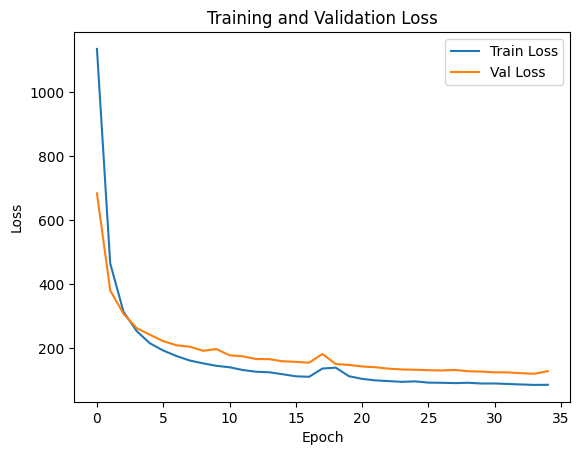

Training complete. Model and scalers saved.


In [ ]:

epochs = 35
batch_size = 512

model = MLPWithAttentionAll(input_dim).to(device)
X_train = train_data.drop(columns=list(target_columns)).values
y_train = train_data[target_columns].values

# standariser
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

scale_tensor = torch.tensor(scaler_y.scale_, dtype=torch.float32, device=device)
mean_tensor = torch.tensor(scaler_y.mean_, dtype=torch.float32, device=device)

# train-validation de 20%
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

X_train_split = torch.tensor(X_train_split, dtype=torch.float32, device=device)
y_train_split = torch.tensor(y_train_split, dtype=torch.float32, device=device)
X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val, dtype=torch.float32, device=device)

train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = RMSE

train_losses = []
val_losses = []

model.train()
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        pred = model(batch_X)

        # déstandariser
        pred_real = pred * scale_tensor + mean_tensor
        batch_y_real = batch_y * scale_tensor + mean_tensor

        #loss de validation
        loss = loss_fn(pred_real, batch_y_real)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # loss de validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_pred_real = val_pred * scale_tensor + mean_tensor
        y_val_real = y_val * scale_tensor + mean_tensor
        val_loss = loss_fn(val_pred_real, y_val_real)

    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# courbes loss
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

torch.save(model.state_dict(), "model.pth")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Training complete. Model and scalers saved.")